In [81]:
# -------------------
# Imports and Setup
# -------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
import joblib

# Stonks Meme Aesthetic
plt.style.use("dark_background")
STONKS_GREEN = '#00ff9c'
STONKS_RED   = '#ff005c'
STONKS_BLUE  = '#00c3ff'
STONKS_PURP  = '#9d4edd'

FIG_DIR = Path("../figures")
FIG_DIR.mkdir(exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# load sequences
X_train = np.load("../Neural Network for Volatility Forecasting/data/processed/X_train.npy")
X_val   = np.load("../Neural Network for Volatility Forecasting/data/processed/X_val.npy")
y_train = np.load("../Neural Network for Volatility Forecasting/data/processed/y_train.npy")
y_val   = np.load("../Neural Network for Volatility Forecasting/data/processed/y_val.npy")

Device: cpu


In [83]:
# --------------------------
# Volatility Optimized LSTM
# --------------------------

class VolatilityLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        
        # Use last timestep output
        out = out[:, -1, :]
        
        out = self.layer_norm(out)
        out = self.fc(out)
        
        return out.squeeze()


# Initialize the Model
input_dim = X_train.shape[2]

model = VolatilityLSTM(input_dim=input_dim).to(device)

criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

In [85]:
# -------------
# Data Loaders
# -------------

train_loader = DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_train, dtype=torch.float32),
        torch.tensor(y_train, dtype=torch.float32)
    ),
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    torch.utils.data.TensorDataset(
        torch.tensor(X_val, dtype=torch.float32),
        torch.tensor(y_val, dtype=torch.float32)
    ),
    batch_size=64,
    shuffle=False
)

In [87]:
# --------------------
# Model Training Loop
# --------------------

EPOCHS = 50
best_val_loss = np.inf
patience = 10
counter = 0

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        preds = model(xb)
        sequence_dates = np.load("../data/processed/sequence_dates.npy", allow_pickle=True)
        loss = criterion(preds, yb)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            sequence_dates = np.load("../data/processed/sequence_dates.npy", allow_pickle=True)
            loss = criterion(preds, yb)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1} | Train {train_loss:.6f} | Val {val_loss:.6f}")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "../models/best_lstm.pt")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1 | Train 0.231202 | Val 0.143996
Epoch 2 | Train 0.173648 | Val 0.118620
Epoch 3 | Train 0.170560 | Val 0.116623
Epoch 4 | Train 0.143318 | Val 0.113598
Epoch 5 | Train 0.135230 | Val 0.106977
Epoch 6 | Train 0.129044 | Val 0.113265
Epoch 7 | Train 0.124772 | Val 0.104932
Epoch 8 | Train 0.124354 | Val 0.113781
Epoch 9 | Train 0.120614 | Val 0.102628
Epoch 10 | Train 0.106304 | Val 0.099682
Epoch 11 | Train 0.106296 | Val 0.099624
Epoch 12 | Train 0.103175 | Val 0.097649
Epoch 13 | Train 0.098576 | Val 0.101449
Epoch 14 | Train 0.099524 | Val 0.099495
Epoch 15 | Train 0.093517 | Val 0.101460
Epoch 16 | Train 0.094702 | Val 0.104363
Epoch 17 | Train 0.094767 | Val 0.100242
Epoch 18 | Train 0.094233 | Val 0.099108
Epoch 19 | Train 0.085726 | Val 0.094256
Epoch 20 | Train 0.087039 | Val 0.093547
Epoch 21 | Train 0.088780 | Val 0.094942
Epoch 22 | Train 0.087412 | Val 0.096436
Epoch 23 | Train 0.091820 | Val 0.098776
Epoch 24 | Train 0.092615 | Val 0.092332
Epoch 25 | Train 0.086246

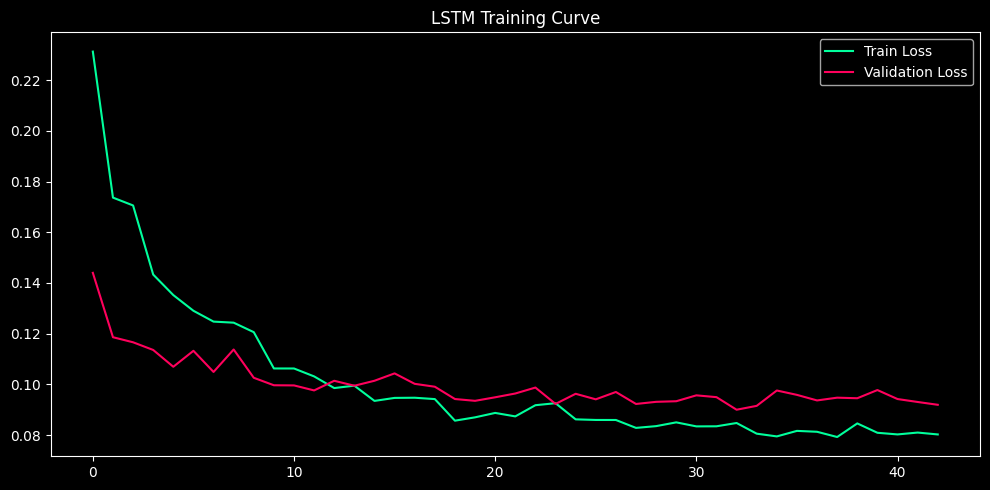

In [89]:
# Training Curve

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss", color=STONKS_GREEN)
plt.plot(val_losses, label="Validation Loss", color=STONKS_RED)
plt.legend()
plt.title("LSTM Training Curve")
plt.tight_layout()
plt.savefig(FIG_DIR / "lstm_training_curve.png", dpi=150)
plt.show()

In [91]:
model.load_state_dict(torch.load("../models/best_lstm.pt"))
model.eval()

with torch.no_grad():
    preds = model(torch.tensor(X_val, dtype=torch.float32).to(device)).cpu().numpy()
    sequence_dates = np.load("../data/processed/sequence_dates.npy", allow_pickle=True)

rmse = np.sqrt(mean_squared_error(y_val, preds))
print("Validation RMSE:", rmse)

Validation RMSE: 0.4859559792292579


In [135]:
# LSTM Predictions
val_dates = sequence_dates[6:]

lstm_pred_df = pd.DataFrame({
    "date": val_dates[0:487],
    "lstm_vol": preds
})

lstm_pred_df.set_index("date", inplace=True)

scaler_y = joblib.load("../models/scaler_y.pkl")

lstm_pred_df["lstm_vol"] = scaler_y.inverse_transform(
    lstm_pred_df["lstm_vol"].values.reshape(-1,1)
).flatten()

# Save these values
lstm_pred_df.to_csv("../Neural Network for Volatility Forecasting/data/processed/lstm_predictions.csv")